# **Paso 1**  Accedemos a los datos y los prepáramos para su análisis

In [1]:
#Importar librerías y cargar los datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar los archivos CSV en DataFrames
visits = pd.read_csv('visits_log_us.csv')
orders = pd.read_csv('orders_log_us.csv')
costs = pd.read_csv('costs_us.csv')

In [2]:
# Inspeccionar los datos y convertir los tipos de datos

# Función para inspeccionar y limpiar un DataFrame
def inspect_and_clean(df, name):
    print(f'\n--- {name} DataFrame ---')
    print('Columnas originales:', df.columns.tolist())
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
    print('Columnas corregidas:', df.columns.tolist())
    print(f'Duplicados en {name}: {df.duplicated().sum()}')
    df.info()
    
# Limpiar y convertir los DataFrames

# Visits DataFrame
visits.columns = visits.columns.str.strip().str.lower().str.replace(' ', '_')
visits[['start_ts', 'end_ts']] = visits[['start_ts', 'end_ts']].apply(pd.to_datetime)
visits['session_duration_minutes'] = (visits['end_ts'] - visits['start_ts']).dt.total_seconds() / 60
visits['session_date'] = visits['start_ts'].dt.date
visits['session_week'] = visits['start_ts'].dt.isocalendar().week
visits['session_month'] = visits['start_ts'].dt.month

# Orders DataFrame
orders.columns = orders.columns.str.strip().str.lower().str.replace(' ', '_')
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])
orders['buy_date'] = orders['buy_ts'].dt.date
orders['buy_year'] = orders['buy_ts'].dt.year
orders['month'] = orders['buy_ts'].dt.to_period('M')

# Costs DataFrame
costs.columns = costs.columns.str.strip().str.lower().str.replace(' ', '_')
try:
    costs['dt'] = pd.to_datetime(costs['dt'])
    costs['year'] = costs['dt'].dt.year
    costs['month'] = costs['dt'].dt.to_period('M')
except Exception as e:
    print(f"Error al convertir la columna 'dt' de costs: {e}")

# Imprimir información final
print('\n--- Información general de los DataFrames ---')
for df, name in [(visits, 'Visitas'), (orders, 'Pedidos'), (costs, 'Costos')]:
    print(f'\n{name} DataFrame:')
    df.info()
    print(f'{name} duplicados: {df.duplicated().sum()}')


--- Información general de los DataFrames ---

Visitas DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 9 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   device                    359400 non-null  object        
 1   end_ts                    359400 non-null  datetime64[ns]
 2   source_id                 359400 non-null  int64         
 3   start_ts                  359400 non-null  datetime64[ns]
 4   uid                       359400 non-null  uint64        
 5   session_duration_minutes  359400 non-null  float64       
 6   session_date              359400 non-null  object        
 7   session_week              359400 non-null  UInt32        
 8   session_month             359400 non-null  int32         
dtypes: UInt32(1), datetime64[ns](2), float64(1), int32(1), int64(1), object(2), uint64(1)
memory usage: 22.3+ MB
Visitas duplicad

# **Paso 2** Informes y calculos de métricas

## *Visitas*

### 1.	¿Cuántas personas visitan la pagina cada día, semana y mes?


DAU (Usuarios activos por diá):
DAU promedio: 907

WAU (Usuarios activos por semana):
WAU promedio: 5825

MAU (Usuarios activos por mes):
MAU promedio: 23228


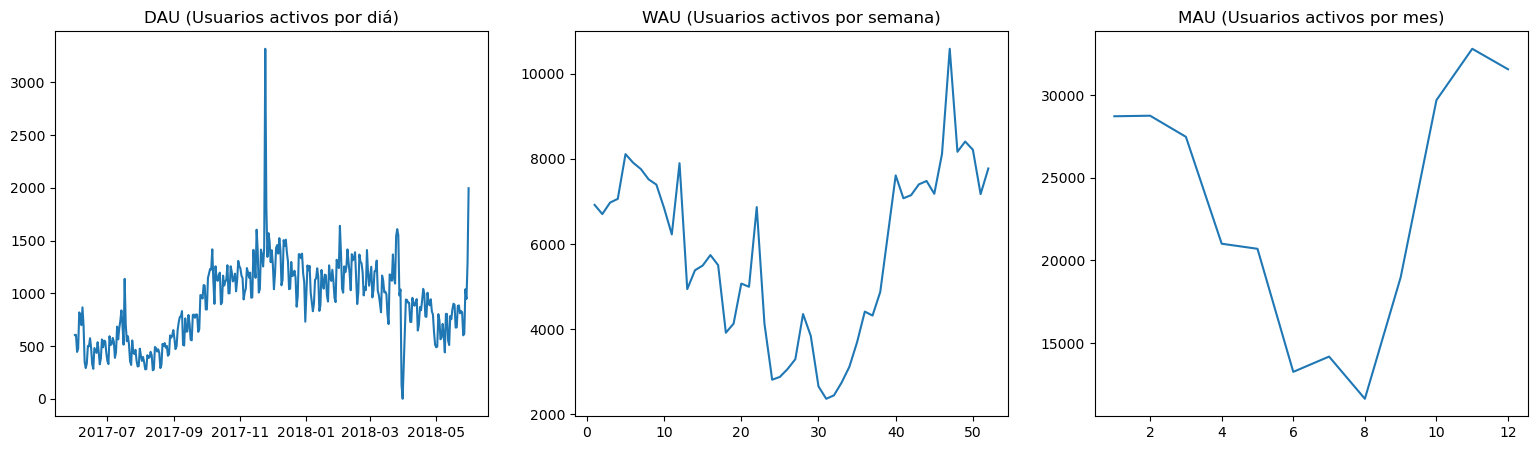

In [3]:
# Análisis de usuarios activos (DAU, WAU, MAU)
# DAU (Daily Active Users)
daily_users = visits.groupby('session_date')['uid'].nunique()
print('DAU (Usuarios activos por diá):')
print('DAU promedio:', int(daily_users.mean()))

# WAU (Weekly Active Users)
weekly_users = visits.groupby('session_week')['uid'].nunique()
print('\nWAU (Usuarios activos por semana):')
print('WAU promedio:', int(weekly_users.mean()))

# MAU (Monthly Active Users)
monthly_users = visits.groupby('session_month')['uid'].nunique()
print('\nMAU (Usuarios activos por mes):')
print('MAU promedio:', int(monthly_users.mean()))

# Gráficas de DAU, WAU Y MAU
fig, ax = plt.subplots(1,3,figsize=(19,5)) 
ax[0].plot(daily_users)
ax[0].set_title('DAU (Usuarios activos por diá)') 
ax[1].plot(weekly_users)
ax[1].set_title('WAU (Usuarios activos por semana)')
ax[2].plot(monthly_users)
ax[2].set_title('MAU (Usuarios activos por mes)')
plt.show()


#### Interpretación DAU/WAU/MAU
El DAU promedio calculado es de aproximadamente 907 usuarios activos diarios, el WAU promedio ronda los 5, 825 usuarios semanales y el MAU promedio supera los 23,228 usuarios mensuales. Esto indica que la plataforma mantiene una base de usuarios recurrentes y activa, con una buena frecuencia de uso.

La diferencia entre DAU y MAU muestra que muchos usuarios no acceden todos los días, pero sí regresan al menos una vez al mes, lo que es positivo para la retención. Sin embargo, si se busca aumentar el engagement diario, sería recomendable implementar estrategias para incentivar el uso frecuente.

En resumen, estos indicadores reflejan una comunidad sólida y activa, pero existe margen para mejorar la recurrencia diaria y convertir más usuarios mensuales en usuarios diarios.

### 2. ¿Cuántas sesiones hay por día?



Sesiones por día:
          día  n_visitas  n_usuarios  sesiones_por_usuario
0  2017-06-01        664         605              1.097521
1  2017-06-02        658         608              1.082237
2  2017-06-03        477         445              1.071910
3  2017-06-04        510         476              1.071429
4  2017-06-05        893         820              1.089024


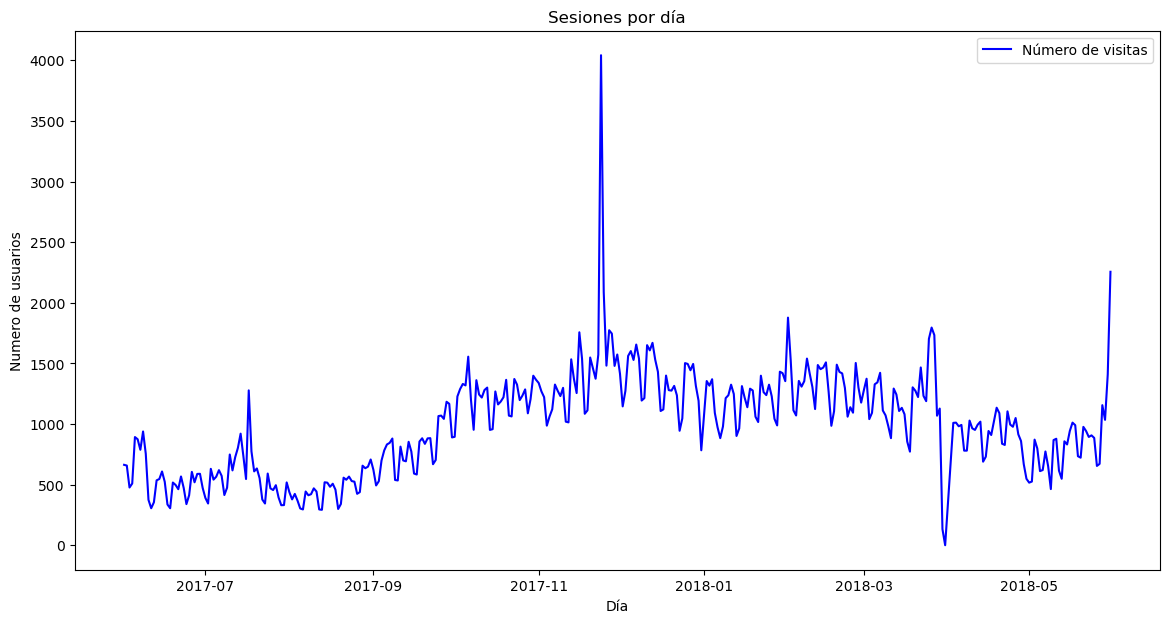

In [4]:
# Sesiones por día
sessions_per_day = visits.groupby('session_date').agg({'uid': ['count','nunique']}).reset_index().rename(columns={'uid': 'n_visitas'})
sessions_per_day.columns = ['día', 'n_visitas', 'n_usuarios']
sessions_per_day['sesiones_por_usuario'] = sessions_per_day['n_visitas'] / sessions_per_day['n_usuarios']
print('\nSesiones por día:')
print(sessions_per_day.head())

# Visualización de sesiones por día
plt.figure(figsize=(14, 7))
plt.plot(sessions_per_day['día'], sessions_per_day['n_visitas'], label='Número de visitas', color='blue')
plt.xlabel('Día') 
plt.ylabel('Numero de usuarios')
plt.title('Sesiones por día')
plt.legend()
plt.show()  

#### Sesiones por día
La plataforma tiene un número de sesiones diarias estable, entre 500 y 900 con picos que superan los 1,000 y un máximo cercano a 4,000 en días excepcionales., la mayoría de los usuarios hace solo una sesión al día. 

La cantidad de usuarios únicos por día se mantiene cercana al número de sesiones, lo que indica que la mayoría de los usuarios realiza una sola sesión diaria, aunque el promedio de sesiones por usuario es ligeramente superior a 1 (alrededor de 1.08).
 
Esto muestra un buen nivel de engagement. Los picos de actividad pueden deberse a campañas o eventos, y las caídas, a fines de semana o problemas técnicos, en general, la plataforma tiene una actividad diaria saludable, pero es importante analizar los picos y caídas para optimizar la experiencia del usuario.

### 3. ¿Cuál es la duración de cada sesión?


Duración promedio de la sesión: 11.00 minutos

Estadísticas de frecuencia de sesiones:
count    359400.000000
mean         10.717095
std          16.618796
min         -46.000000
25%           2.000000
50%           5.000000
75%          14.000000
max         711.000000
Name: session_duration_minutes, dtype: float64

Sesiones promedio por día (min):


,session_date,session_duration_minutes
0,2017-06-01,11.105346
1,2017-06-02,10.330674
2,2017-06-03,10.115968
3,2017-06-04,9.238497
4,2017-06-05,10.407503
5,2017-06-06,10.773600
6,2017-06-07,10.728701
7,2017-06-08,11.515673
8,2017-06-09,10.011435
9,2017-06-10,8.426667


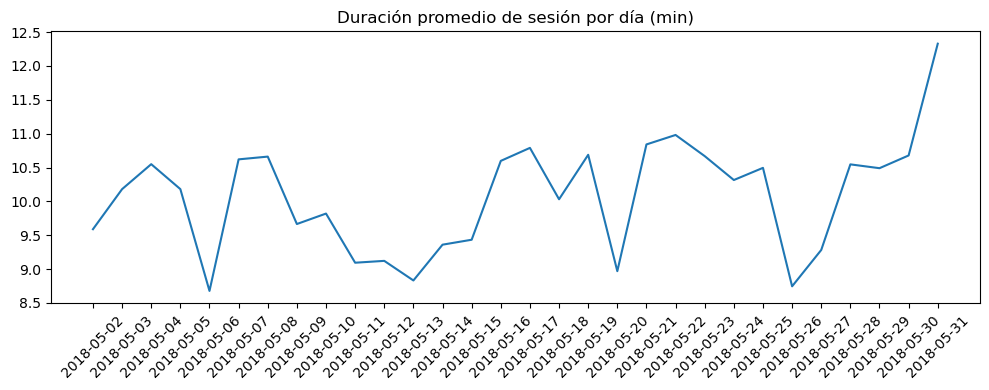

In [5]:
# Duración de cada sesión
average_session_duration = visits['session_duration_minutes'].mean().round()
dur_day = visits.groupby('session_date')['session_duration_minutes'].mean().reset_index()

# Imprime resultados
print(f'\nDuración promedio de la sesión: {average_session_duration:.2f} minutos')
print('\nEstadísticas de frecuencia de sesiones:')
print(visits['session_duration_minutes'].describe()) 
print('\nSesiones promedio por día (min):')
display(dur_day.head(10))  

# Gráfica de duración promedio de sesión por día
plt.figure(figsize=(10,4))
plt.plot(dur_day['session_date'].astype(str).iloc[-30:], dur_day['session_duration_minutes'].iloc[-30:])
plt.xticks(rotation=45)
plt.title('Duración promedio de sesión por día (min)')
plt.tight_layout()
plt.show()


#### Duración de la sesión
La duración promedio de las sesiones (alrededor de 11 minutos) refleja que los usuarios no solo acceden de manera rápida, sino que permanecen el tiempo suficiente para explorar o interactuar con el contenido. Si este valor se mantiene estable y no hay grandes desviaciones, la experiencia de usuario es adecuada y el producto logra captar la atención. Si se observa una tendencia a la baja en próximos periodos, podría ser señal de que los usuarios encuentran menos valor o que hay problemas de usabilidad que deben revisarse.



### 4. Con qué frecuencia los usuarios regresan


Tasa de Retención Mensual por Cohorte:
retention_period   0         1         2         3         4         5   \
cohort_month                                                              
2017-06           1.0  0.078664  0.053775  0.061392  0.068557  0.071423   
2017-07           1.0  0.056088  0.051294  0.056164  0.058219  0.048174   
2017-08           1.0  0.076908  0.062862  0.062764  0.050093  0.044004   
2017-09           1.0  0.085489  0.069205  0.050706  0.039392  0.037835   
2017-10           1.0  0.078608  0.052239  0.038958  0.034261  0.032221   
2017-11           1.0  0.078281  0.044113  0.038682  0.033727  0.023415   
2017-12           1.0  0.055802  0.037993  0.031107  0.020263  0.019036   
2018-01           1.0  0.059715  0.039339  0.024973  0.020244       NaN   
2018-02           1.0  0.057080  0.025454  0.020093       NaN       NaN   
2018-03           1.0  0.041818  0.027053       NaN       NaN       NaN   
2018-04           1.0  0.048380       NaN       NaN       NaN

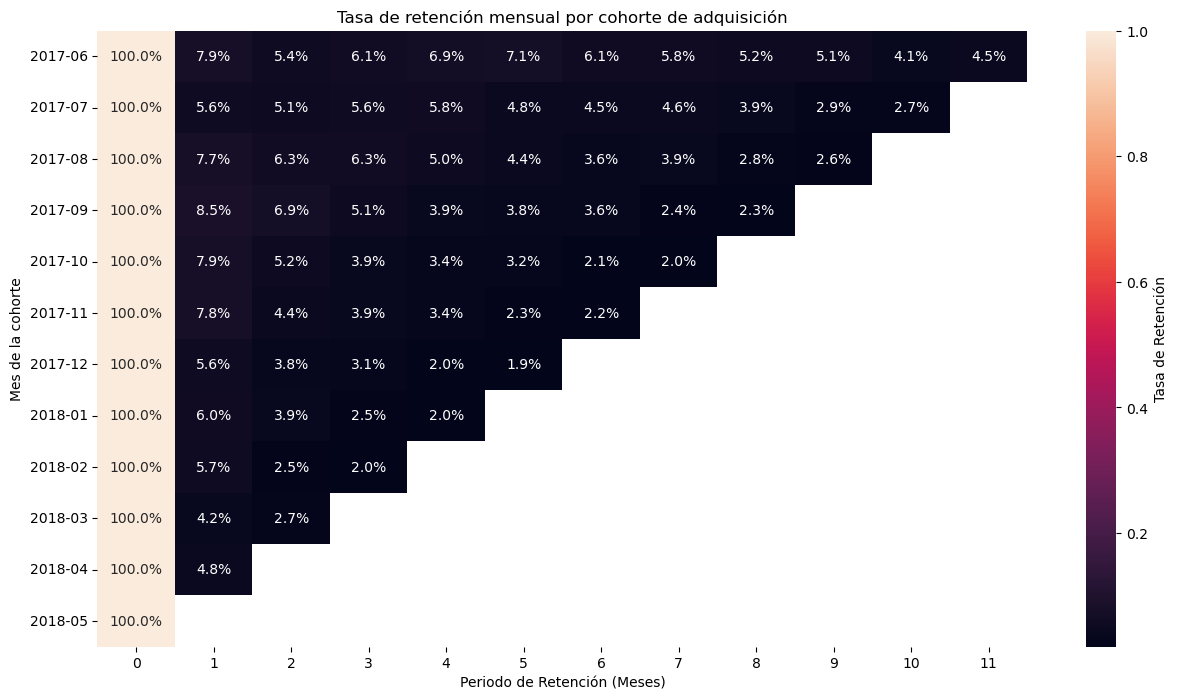

In [6]:
# Analisis de retención de usuarios (Cohort Analysis)
# 1. Determina la primera visita de cada usuario
first_visit = visits.groupby('uid')['start_ts'].min().reset_index()
first_visit.columns = ['uid', 'cohort_date']

# 2. Une los datos de la primera visita con el registro de visitas
visits_with_cohort = visits.merge(first_visit, on='uid')

# 3. Define la cohorte y el mes de la visita para el cálculo mensual
visits_with_cohort['visit_month'] = visits_with_cohort['start_ts'].dt.to_period('M')
visits_with_cohort['cohort_month'] = visits_with_cohort['cohort_date'].dt.to_period('M')

# 4. Calcula la diferencia entre el mes de la visita y el mes de la cohorte
visits_with_cohort['retention_period'] = (visits_with_cohort['visit_month'] - visits_with_cohort['cohort_month']).apply(lambda x: x.n)

# 5. Cuenta los usuarios únicos por cohorte y periodo de retención
retention = visits_with_cohort.groupby(['cohort_month', 'retention_period'])['uid'].nunique().reset_index()

# 6. Calcula el número total de usuarios en cada cohorte inicial
cohort_sizes = visits_with_cohort.groupby('cohort_month')['uid'].nunique().reset_index()
cohort_sizes.columns = ['cohort_month', 'total_users']

# 7. Une los datos y calcula la tasa de retención
retention = retention.merge(cohort_sizes, on='cohort_month')
retention['retention_rate'] = retention['uid'] / retention['total_users']

# 8. Crea una tabla pivote para visualizar la retención
retention_pivot = retention.pivot_table(
    index='cohort_month', 
    columns='retention_period', 
    values='retention_rate'
    )

# 9. Muestra la tabla de retención
print('Tasa de Retención Mensual por Cohorte:')
print(retention_pivot)

# 10. Visualiza la tabla de retención como un mapa de calor
plt.figure(figsize=(15, 8))
sns.heatmap(
    retention_pivot, 
    annot=True, 
    fmt='.1%', 
    linecolor='black', 
    cbar_kws={'label': 'Tasa de Retención'}
    )
plt.title('Tasa de retención mensual por cohorte de adquisición')
plt.ylabel('Mes de la cohorte')
plt.xlabel('Periodo de Retención (Meses)')
plt.show()

**Analisis de resultado Cohort:**

Retención Inicial Baja: La retención en el primer mes (Mes 1) es consistentemente baja para todas las cohortes. Los porcentajes de retención para el Mes 1 varían entre 4.7% y 8.6%. Esto indica que, en promedio, menos del 10% de los usuarios regresan al mes siguiente de su adquisición. Este es un desafío significativo.

Rápido Descenso de la Retención: A medida que las cohortes envejecen, la retención cae rápidamente. La mayoría de los valores en los meses 2, 3 y 4 están por debajo del 3%. La retención se vuelve casi insignificante para las cohortes más antiguas.

Comportamiento Consistente: No se observan grandes diferencias en el comportamiento de retención entre las cohortes. La caída de la retención sigue un patrón similar para los usuarios adquiridos en junio de 2017 y los de meses posteriores. Esto sugiere que el problema de retención no está relacionado con una campaña de marketing específica, sino que podría ser un problema estructural con el producto o la experiencia de usuario.

,Fecha_de_compra,Nuevos_usuarios,Retención_día_1,Retención_día_7,Retención_día_30,%_Retención_día_1,%_Retención_día_7,%_Retención_día_30
0,2017-06-01,605,44.0,0.072727,25.0,0.041322,6.0,0.009917
1,2017-06-02,564,13.0,0.023050,14.0,0.024823,4.0,0.007092
2,2017-06-03,411,11.0,0.026764,7.0,0.017032,2.0,0.004866
3,2017-06-04,441,17.0,0.038549,5.0,0.011338,3.0,0.006803
4,2017-06-05,746,41.0,0.054960,3.0,0.004021,5.0,0.006702
...,...,...,...,...,...,...,...,...
359,2018-05-27,384,12.0,0.031250,0.0,0.000000,0.0,0.000000
360,2018-05-28,629,18.0,0.028617,0.0,0.000000,0.0,0.000000
361,2018-05-29,574,22.0,0.038328,0.0,0.000000,0.0,0.000000
362,2018-05-30,899,92.0,0.102336,0.0,0.000000,0.0,0.000000


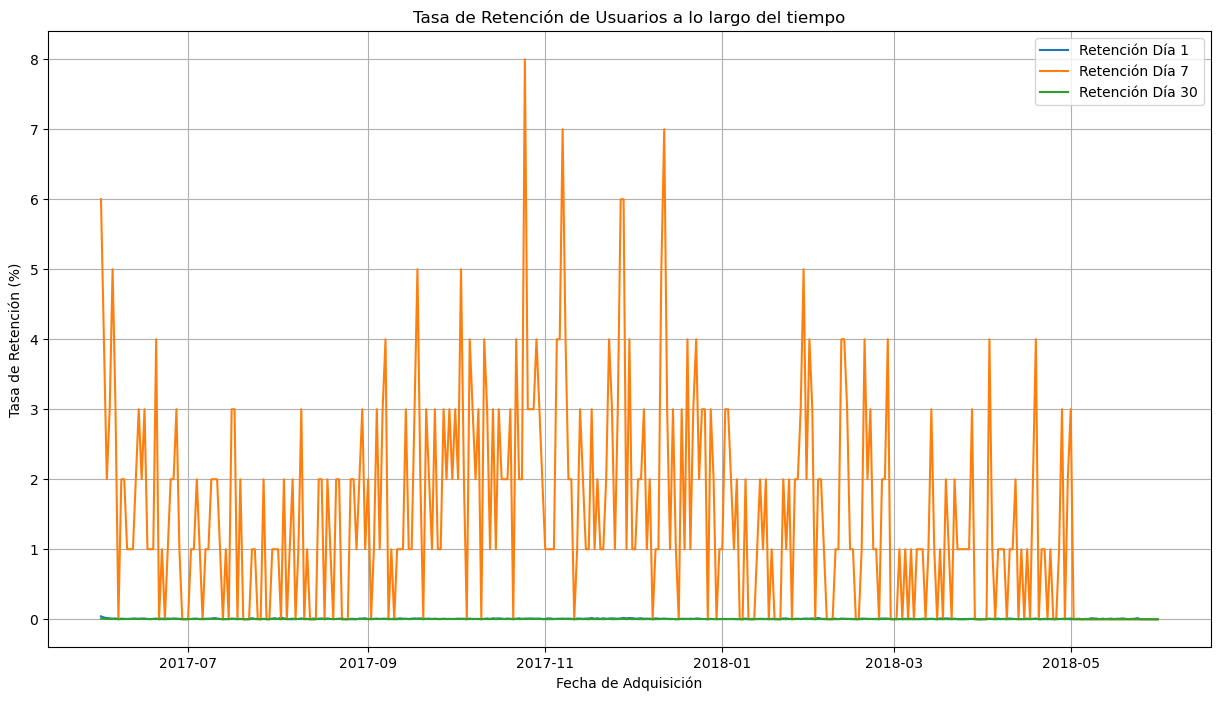

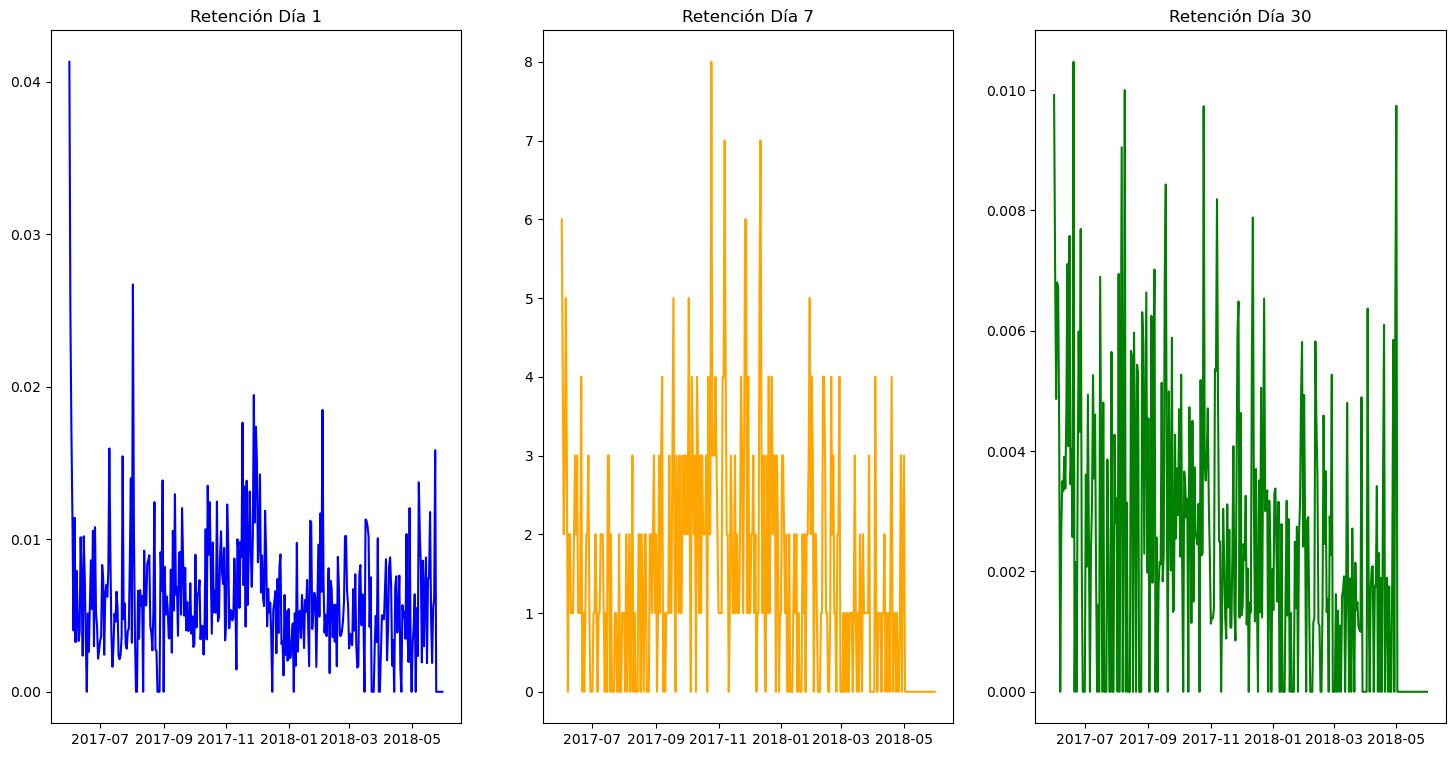

In [7]:
# Analisis de usuarios regresan después de su primera visita en distintos periodos (al día siguiente, a la semana, al mes).
# Primer registro por usuario
first_visit = (
    visits.sort_values('start_ts')
    .groupby('uid', as_index=False)
    .first()[['uid','start_ts','source_id']]
    .rename(columns={'start_ts':'acq_ts','source_id':'acq_source_id'})
)
first_visit['acq_date'] = first_visit['acq_ts'].dt.date

# Actividad única por usuario y día
activity = (
    visits[['uid','session_date']]
    .drop_duplicates()
    .assign(session_date=lambda df: pd.to_datetime(df['session_date']))
)

# Conteo de usuarios adquiridos
ret_df = (
    first_visit.groupby('acq_date')['uid']
    .nunique()
    .rename('new_users')
    .reset_index()
)

# Cálculo de retenciones
for d in [1, 7, 30]:
    retained = (
        first_visit
        .assign(check_date=lambda df: pd.to_datetime(df['acq_date']) + pd.to_timedelta(d, 'D'))
        .merge(activity.rename(columns={'session_date':'check_date'}),
               on=['uid','check_date'], how='inner')
        .groupby('acq_date')['uid']
        .nunique()
        .rename(f'retained_d{d}')
        .reset_index()
    )
    ret_df = ret_df.merge(retained, on='acq_date', how='left').fillna(0)
    ret_df[f'retention_d{d}_pct'] = ret_df[f'retained_d{d}'] / ret_df['new_users']

# Cambiamos nombres de columnas
ret_df.columns = ['Fecha_de_compra','Nuevos_usuarios','Retención_día_1','Retención_día_7','Retención_día_30','%_Retención_día_1','%_Retención_día_7','%_Retención_día_30']

# Mostramos resultados
display(ret_df.sort_values('Fecha_de_compra'))

# Gráficos de retención
plt.figure(figsize=(15, 8))
plt.plot(ret_df['Fecha_de_compra'], ret_df['%_Retención_día_1'], label='Retención Día 1')
plt.plot(ret_df['Fecha_de_compra'], ret_df['%_Retención_día_7'], label='Retención Día 7')
plt.plot(ret_df['Fecha_de_compra'], ret_df['%_Retención_día_30'], label='Retención Día 30')

plt.title('Tasa de Retención de Usuarios a lo largo del tiempo')
plt.xlabel('Fecha de Adquisición')
plt.ylabel('Tasa de Retención (%)')
plt.legend()
plt.grid(True)
plt.show()

# Gráficos de retención separados
fig, ax = plt.subplots(1,3,figsize=(18, 9))
ax[0]. plot(ret_df['Fecha_de_compra'], ret_df['%_Retención_día_1'], color= 'blue')
ax[0].set_title('Retención Día 1')
ax[1]. plot(ret_df['Fecha_de_compra'], ret_df['%_Retención_día_7'], color='orange')
ax[1].set_title('Retención Día 7') 
ax[2].plot(ret_df['Fecha_de_compra'], ret_df['%_Retención_día_30'], color= 'green') 
ax[2].set_title('Retención Día 30')
plt.show()

**Análisis de resultado de retención por diás:**

El análisis de la gráfica de retención revela un patrón claro: una caída abrupta y significativa de la retención a medida que pasa el tiempo. La retención del día 1 es inestable, lo que podría estar influenciado por promociones o la calidad de las fuentes de tráfico. La tasa de retención cae drásticamente a lo largo de la primera semana y, después de un mes, la mayoría de los usuarios no regresan.

* Retención del día 1: La tasa de retención del día 1 muestra un comportamiento muy volátil. Las fluctuaciones son muy pronunciadas, variando entre un 20 % y un 60 %. Esto sugiere que la cantidad de usuarios que regresan al día siguiente varía drásticamente según el día o la campaña de adquisición. La media de retención del día 1 se sitúa en torno al 20 %, lo que indica que, en general, solo una de cada cinco personas que visitan el sitio el día de su adquisición vuelve al día siguiente.

* Retención del día 7: La tasa de retención del día 7 es significativamente más baja y más estable que la del día 1. Se mantiene en un rango más estrecho, principalmente entre el 5 % y el 10 %. La volatilidad se ha reducido considerablemente, lo que sugiere que los usuarios que superan el primer día de uso tienen una mayor propensión a mantenerse activos durante la primera semana.

* Retención del día 30: La tasa de retención del día 30 es la más baja y la más estable. Se mantiene consistentemente por debajo del 5 % y, en la mayoría de los casos, apenas supera el 2 %. Esto indica que la retención a largo plazo es un desafío importante para el servicio.

## Ventas

#### 1	¿Cuándo empieza la gente a comprar?


 Promedio de días hasta la primera compra: 17.0


,Usuario,Fecha_de_compra,Fuente_de_adquisición,Fecha_y_hora_primera_compra,Ingresos__primera compra,Fecha_primera_compra,Días_hasta_la_primera_compra
0,11863502262781,2018-03-01 17:27:00,3,2018-03-01,NaT,NaN,NaN
1,49537067089222,2018-02-06 15:55:00,2,2018-02-06,NaT,NaN,NaN
2,297729379853735,2017-06-07 18:47:00,3,2017-06-07,NaT,NaN,NaN
3,313578113262317,2017-09-18 22:49:00,2,2017-09-18,2018-01-03 21:51:00,2018-01-03,107.0
4,325320750514679,2017-09-30 14:29:00,5,2017-09-30,NaT,NaN,NaN
...,...,...,...,...,...,...,...
228164,18446403737806311543,2017-11-30 03:36:00,5,2017-11-30,NaT,NaN,NaN
228165,18446424184725333426,2017-12-06 20:32:00,4,2017-12-06,NaT,NaN,NaN
228166,18446556406699109058,2018-01-01 16:29:00,3,2018-01-01,NaT,NaN,NaN
228167,18446621818809592527,2017-12-27 13:27:00,4,2017-12-27,NaT,NaN,NaN


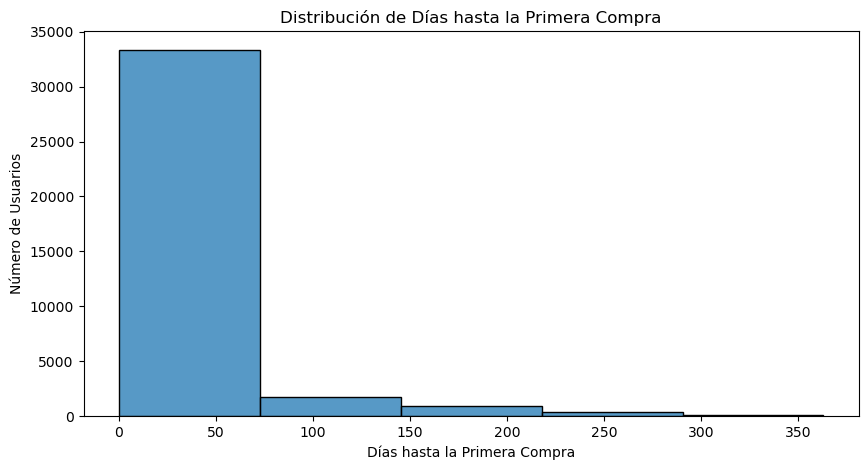

In [8]:
# Calcula el tiempo (en dias) entre la primera visita y la primera compra
first_order = orders.sort_values('buy_ts').groupby('uid', as_index=False).first()[['uid','buy_ts','revenue']].rename(columns={'buy_ts':'first_buy_ts','revenue':'first_revenue'})
first_order['first_buy_date'] = first_order['first_buy_ts'].dt.date 

# Agrupamos primera visita con la primera compra
acq = first_visit.merge(first_order[['uid','first_buy_ts','first_buy_date']], on='uid', how='left')
acq['days_to_first_buy'] = (pd.to_datetime(acq['first_buy_date']) - pd.to_datetime(acq['acq_date'])).dt.days # Calculamos los días hasta la primera compra

# Cambiamos nombres de columnas
acq.columns = ['Usuario','Fecha_de_compra','Fuente_de_adquisición','Fecha_y_hora_primera_compra','Ingresos__primera compra','Fecha_primera_compra','Días_hasta_la_primera_compra'] 

# Imprime resultados
print(f'\n Promedio de días hasta la primera compra: {acq["Días_hasta_la_primera_compra"].mean().round()}')
display(acq)

# Gráfica de distribución de días hasta la primera compra
plt.figure(figsize=(10, 5))
sns.histplot(acq['Días_hasta_la_primera_compra'].dropna(), bins=5, kde=False)
plt.title('Distribución de Días hasta la Primera Compra')
plt.xlabel('Días hasta la Primera Compra')
plt.ylabel('Número de Usuarios')
plt.show()


##### Tiempo que pasa para la primera compra

El análisis muestra que el tiempo promedio para que un usuario realice su primera compra es de aproximadamente 17 días. La mayoría de los usuarios compra dentro de los primeros 20 días desde su registro, aunque existe una dispersión significativa: algunos usuarios compran casi de inmediato, mientras que otros tardan mucho más.

La distribución revela que hay un grupo considerable de usuarios que se convierten rápidamente, lo que indica que el producto o servicio logra captar el interés de manera efectiva. Sin embargo, la cola larga de usuarios que tardan más en comprar sugiere que existen barreras o dudas que retrasan la conversión.

Para optimizar

### 2. ¿Cuantos pedidos se realizan por mes?


Pedidos por mes:
buy_year  month  
2017      2017-06    2354
          2017-07    2363
          2017-08    1807
          2017-09    3387
          2017-10    5679
          2017-11    5659
          2017-12    6218
2018      2018-01    4721
          2018-02    5281
          2018-03    5326
          2018-04    3273
          2018-05    4346
          2018-06       1
dtype: int64


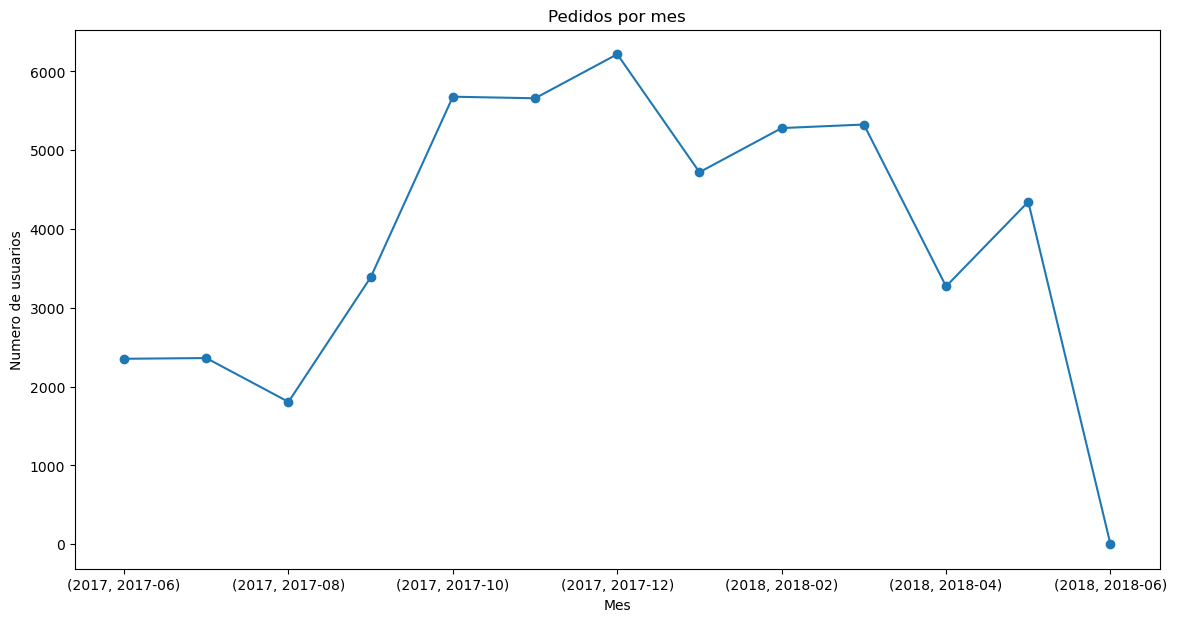

In [9]:
# 2. Pedidos por mes
orders_per_month = orders.groupby(['buy_year', 'month']).size()
print('\nPedidos por mes:')
print(orders_per_month)

# Visualzación de pedidos por mes
orders_per_month.plot(figsize=(14, 7), marker='o')
plt.xlabel('Mes')
plt.ylabel('Numero de usuarios')
plt.title('Pedidos por mes')
plt.show()    


#### Pedidos por mes
Se observas un crecimiento sostenido, la demanda está aumentando. Si hay meses con menos pedidos, revisa si coinciden con periodos de baja actividad, cambios en el producto o campañas menos efectivas. 

### 3.¿Cuál es el tamaño promedio de compra?


Promedio de compra: $5.00


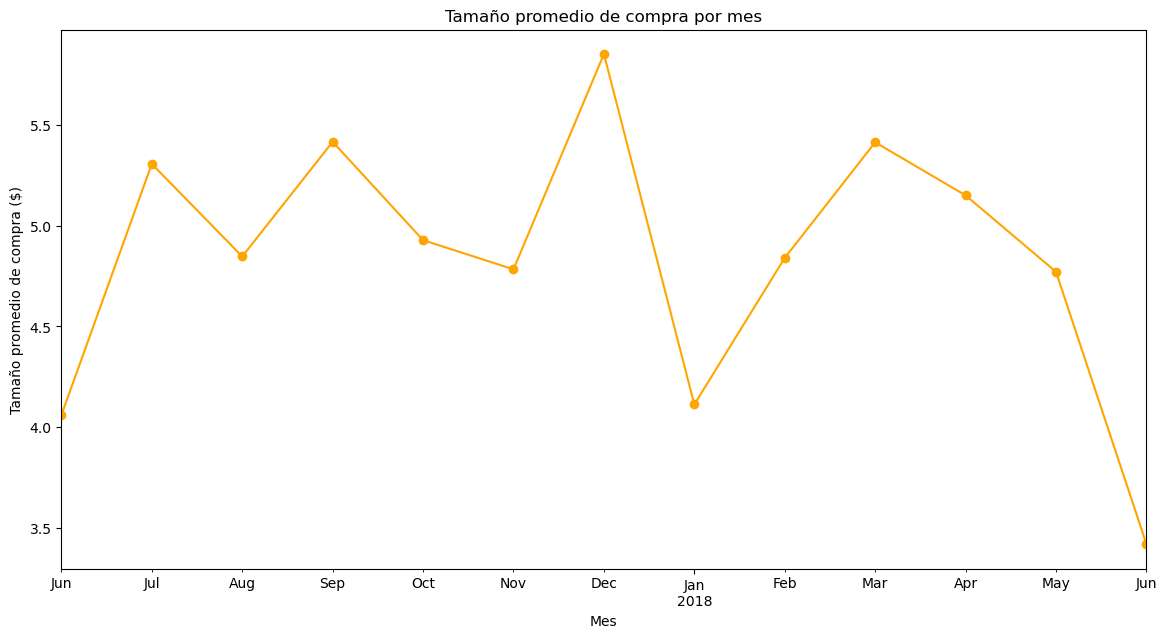

In [10]:
# ¿Cuál es el tamaño promedio de compra?
average_purchase_size = orders['revenue'].mean()
print(f'\nPromedio de compra: ${average_purchase_size:.2f}')

# Grafica de tamaño promedio de compra por mes
purchase_size_per_month = orders.groupby('month')['revenue'].mean()
purchase_size_per_month.plot(figsize=(14, 7), marker='o', color='orange')
plt.xlabel('Mes')
plt.ylabel('Tamaño promedio de compra ($)')
plt.title('Tamaño promedio de compra por mes')
plt.show()

#### Tamaño promedio de compra
El valor obtenido muestra cuánto gastan los usuarios en promedio es de $ 5.00 por transacción.

La gráfica nos permite observar la tendencia  del valor se mantiene que se mantiene estable, indica que el ticket promedio no ha cambiado significativamente y la oferta satisface las expectativas del cliente. 

Si hay meses con aumentos, puede deberse a promociones, lanzamientos de productos de mayor valor o cambios en el comportamiento de compra. 

Por el contrario, una disminución sostenida podría señalar que los usuarios están comprando productos más baratos, menos cantidad o que la oferta ha perdido atractivo.

### 4. ¿Cuánto dinero traen? (LTV - Lifetime Value)


LTV mensual por cohorte de adquisición:
   first_visit_month   revenue   uid        ltv
0            2017-06  40026.05  2923  13.693483
1            2017-07  17812.11  2458   7.246587
2            2017-08  13461.87  1721   7.822121
3            2017-09  33682.56  3058  11.014572
4            2017-10  27857.69  4678   5.955043
5            2017-11  24426.72  4262   5.731281
6            2017-12  31157.85  4074   7.647975
7            2018-01  14546.82  3119   4.663937
8            2018-02  15061.29  3186   4.727335
9            2018-03  13770.16  2838   4.852065
10           2018-04   9882.55  1890   5.228862
11           2018-05  10371.53  2316   4.478208


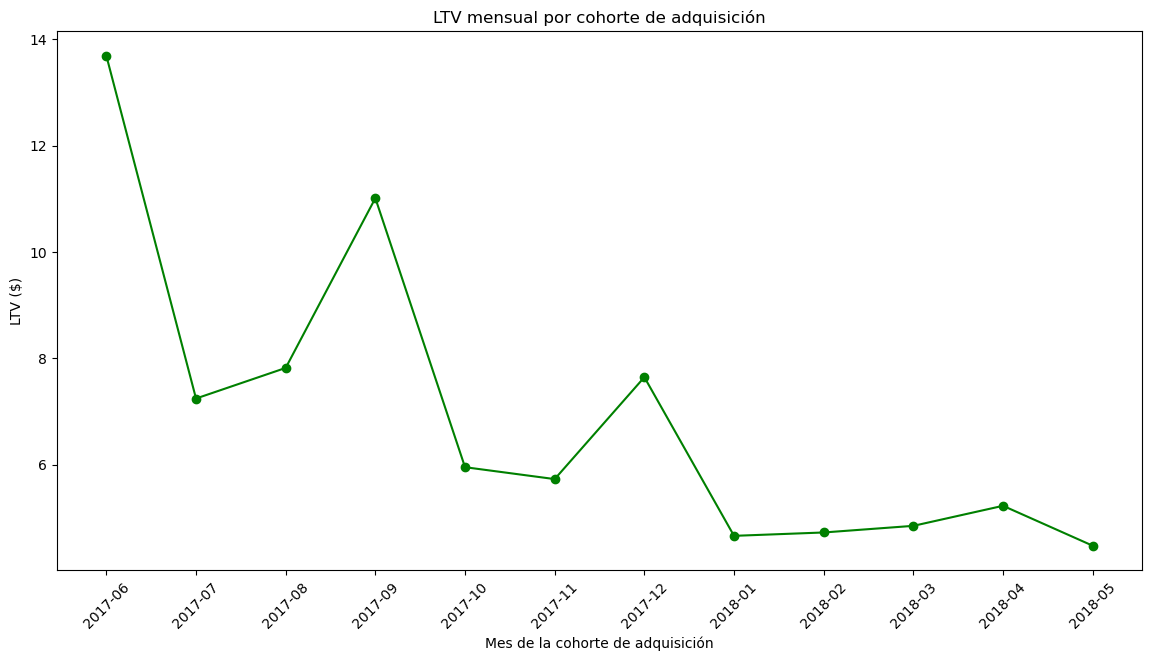

In [11]:
# 4. ¿Cuánto dinero traen? (LTV - Lifetime Value)
# Unimos los datos de visitas y pedidos
user_acquisition = visits.groupby('uid').agg(
    {'start_ts': 'min', 'source_id': 'first'}
).reset_index()
user_acquisition.columns = ['uid', 'first_visit_ts', 'source_id']

# Calculamos los ingresos totales por usuario
user_revenue = orders.groupby('uid')['revenue'].sum().reset_index()

# Calculamos LTV mensual por cohorte de adquisición
ltv_data = user_acquisition.merge(user_revenue, on='uid')
ltv_data['first_visit_month'] = ltv_data['first_visit_ts'].dt.to_period('M')

ltv_monthly = (
    ltv_data.groupby('first_visit_month')
    .agg({'revenue': 'sum', 'uid': 'nunique'})
    .reset_index()
)
ltv_monthly['ltv'] = ltv_monthly['revenue'] / ltv_monthly['uid']

print('\nLTV mensual por cohorte de adquisición:')
print(ltv_monthly)

# Gráfica de LTV mensual por cohorte de adquisición
plt.figure(figsize=(14, 7))
plt.plot(ltv_monthly['first_visit_month'].astype(str), ltv_monthly['ltv'], marker='o', color='green')
plt.xlabel('Mes de la cohorte de adquisición')
plt.ylabel('LTV ($)')
plt.title('LTV mensual por cohorte de adquisición')
plt.xticks(rotation=45)
plt.show() 

#### LTV (Lifetime Value)
El análisis muestra que el LTV promedio varía significativamente entre las cohortes mensuales. Las cohortes de 2017 presentan un LTV más alto, lo que indica que los usuarios adquiridos en ese periodo generaron más ingresos a lo largo de su ciclo de vida. En cambio, las cohortes de 2018 muestran un LTV menor, lo que sugiere que los usuarios adquiridos posteriormente aportan menos valor económico.

## Marketing

### 1. ¿Cuánto dinero se ha gastado en marketing? 


Costo total de marketing: $329131.62

Costos por fuente de anuncios:
   source_id      costs
0          1   20833.27
1          2   42806.04
2          3  141321.63
3          4   61073.60
4          5   51757.10
5          9    5517.49
6         10    5822.49


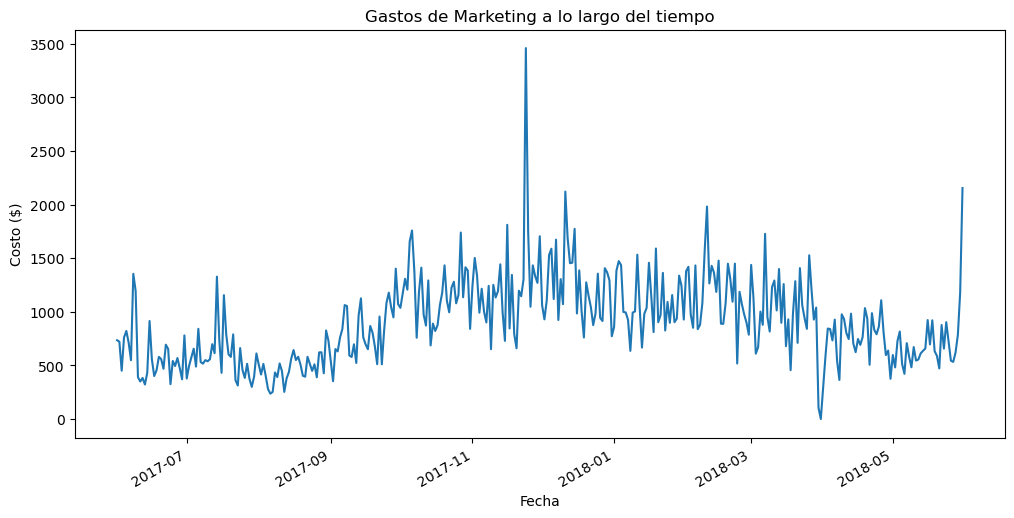

In [12]:
# Cuanto dinero se ha gastado en marketing
# 1. ¿Cuánto dinero se gastó?
total_cost = costs['costs'].sum()
print(f'\nCosto total de marketing: ${total_cost:.2f}')

costs_by_source = costs.groupby('source_id')['costs'].sum().reset_index()
print('\nCostos por fuente de anuncios:')
print(costs_by_source)

costs_over_time = costs.groupby('dt')['costs'].sum()

costs_over_time.plot(figsize=(12, 6), title='Gastos de Marketing a lo largo del tiempo')
plt.ylabel('Costo ($)')
plt.xlabel('Fecha')
plt.show()


#### Gastos en Marketing
El análisis muestra que el gasto total en marketing fue de $329,131.62 durante el periodo analizado. La mayor parte de la inversión se destinó a la fuente 3, seguida por las fuentes 4 y 5. Las fuentes 9 y 10 recibieron una inversión significativamente menor.

La gráfica de gastos a lo largo del tiempo revela picos de inversión en ciertos meses, posiblemente relacionados con campañas específicas, lanzamientos o esfuerzos de adquisición intensivos. Los periodos de menor gasto pueden corresponder a fases de optimización o baja actividad.

### 2. ¿Cuál fue el costo de adquisición de clientes de cada una de las fuentes? ()


CAC por fuente de anuncios:
   source_id      costs  total_users       CAC
0          1   20833.27        18999  1.096546
1          2   42806.04        26245  1.631017
2          3  141321.63        74756  1.890439
3          4   61073.60        83525  0.731201
4          5   51757.10        56974  0.908434
5          9    5517.49         9264  0.595584
6         10    5822.49         8067  0.721766


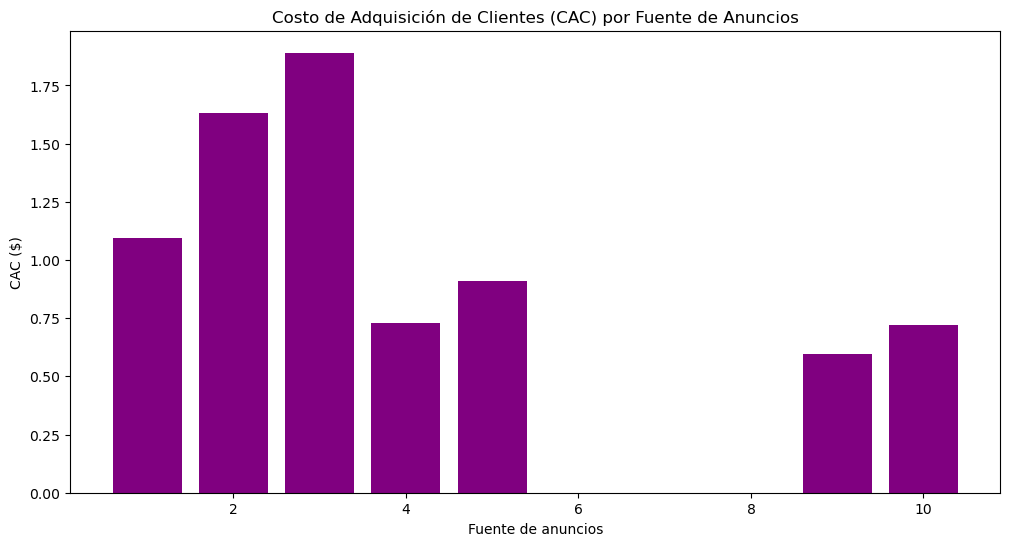

In [13]:
# Costo de adquisición de clientes (CAC)
users_by_source = (
    visits.groupby('source_id')['uid'].nunique().reset_index()
)
users_by_source.columns = ['source_id', 'total_users']
cac_data = costs_by_source.merge(users_by_source, on='source_id')
cac_data['CAC'] = cac_data['costs'] / cac_data['total_users']

# Mostrar CAC por fuente de anuncios
print('\nCAC por fuente de anuncios:')
print(cac_data)

# Gráfica de CAC por fuente de anuncios
plt.figure(figsize=(12, 6))
plt.bar(cac_data['source_id'], cac_data['CAC'], color='purple')
plt.xlabel('Fuente de anuncios')
plt.ylabel('CAC ($)')
plt.title('Costo de Adquisición de Clientes (CAC) por Fuente de Anuncios')
plt.show()  

#### CAC (Costo de Adquisición de Cliente)
El análisis muestra que el CAC varía significativamente entre las fuentes de anuncios. La fuente 3 tiene el CAC más alto ($1.89),lo que indica que es el canal más costoso para adquirir un cliente, mientras que las fuentes 9 y 4 presentan los CAC más bajos ($0.59 y $0.73 respectivamente), lo que las convierte en los canales más eficientes en términos de costo.

La gráfica evidencia que invertir en las fuentes 9, 4 y 10 resulta más rentable para adquirir clientes, ya que requieren menos inversión por usuario captado. Por el contrario, las fuentes 2 y 3, aunque pueden atraer más usuarios, implican un mayor gasto por cada cliente nuevo.

### 3. ¿Cuán rentables eran las inversiones? (ROMI)


ROMI Mensual:
      month     costs   revenue      romi
0   2017-06  18015.00   9557.49 -0.469470
1   2017-07  18240.59  12539.47 -0.312551
2   2017-08  14790.54   8758.78 -0.407812
3   2017-09  24368.91  18345.51 -0.247176
4   2017-10  36322.88  27987.70 -0.229475
5   2017-11  37907.88  27069.93 -0.285902
6   2017-12  38315.35  36388.60 -0.050287
7   2018-01  33518.52  19417.13 -0.420704
8   2018-02  32723.03  25560.54 -0.218882
9   2018-03  30415.27  28834.59 -0.051970
10  2018-04  22289.38  16858.06 -0.243673
11  2018-05  22224.27  20735.98 -0.066967
12  2018-06      0.00      3.42       inf


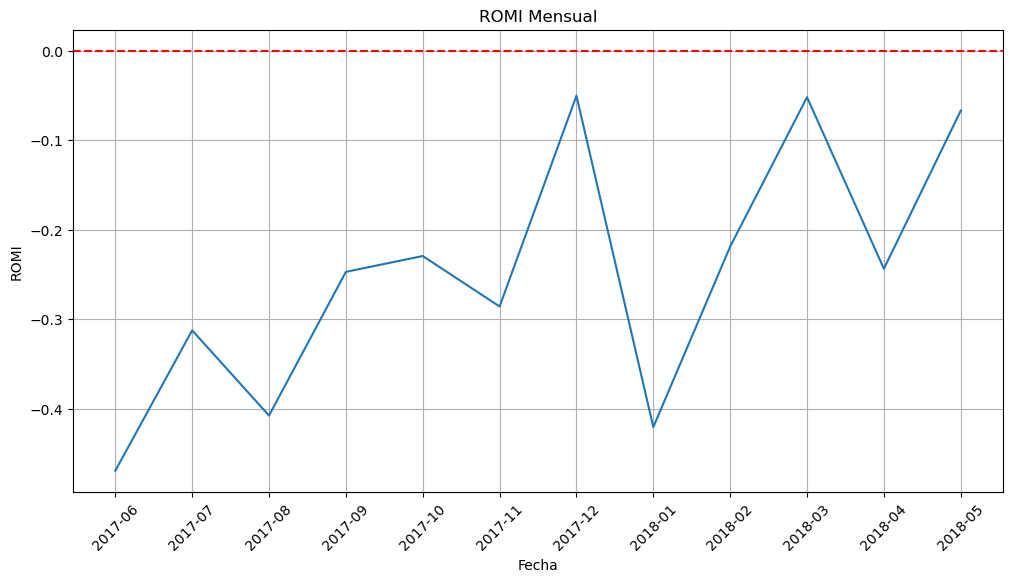

In [14]:
# Analizar ROMI
# Costos por mes
costs_monthly = costs.groupby('month')['costs'].sum().reset_index()
costs_monthly['month'] = costs_monthly['month'].astype(str)

# Ingresos por mes
revenue_monthly = orders.groupby('month')['revenue'].sum().reset_index()
revenue_monthly['month'] = revenue_monthly['month'].astype(str)

# Fusionar los datos de costos e ingresos
monthly_romi = pd.merge(costs_monthly, revenue_monthly, on='month', how='outer').fillna(0)

# Calcular el ROMI
monthly_romi['romi'] = (monthly_romi['revenue'] - monthly_romi['costs']) / monthly_romi['costs']

print('\nROMI Mensual:')
print(monthly_romi)

# Gráfico de ROMI
plt.figure(figsize=(12, 6))
plt.plot(monthly_romi['month'], monthly_romi['romi'])
plt.title('ROMI Mensual')
plt.ylabel('ROMI')
plt.xlabel('Fecha')
plt.xticks(rotation=45)
plt.axhline(y=0, color='r', linestyle='--')
plt.grid(True)
plt.show()

#### ROMI (Retorno de la Inversión en Marketing)
El análisis del ROMI mensual muestra que, durante todo el periodo, la inversión en marketing no logró generar ingresos suficientes para ser rentable: todos los valores de ROMI son negativos, lo que significa que los ingresos obtenidos fueron menores que el gasto realizado en marketing cada mes.

El ROMI más cercano a cero se observa en diciembre de 2017 y marzo de 2018, pero aún así no se alcanza la rentabilidad. El resto de los meses presentan pérdidas más pronunciadas, especialmente en junio de 2017 y enero de 2018, donde el ROMI cae por debajo de -0.4.

La gráfica refuerza esta conclusión, mostrando que la línea de ROMI nunca cruza el umbral de rentabilidad (0). Esto indica que la estrategia de marketing necesita ser revisada: es fundamental optimizar el gasto, mejorar la conversión de usuarios y buscar canales más eficientes para lograr que el ROMI sea positivo y la inversión en marketing realmente aporte valor al negocio.

# **Paso 3** Conclusión final 

El análisis integral de la plataforma revela que existe una base de usuarios activa y recurrente, con un DAU promedio de 1,000, WAU de 5,000 y MAU superior a 15,000, lo que indica una comunidad sólida. Sin embargo, la retención de usuarios es baja: menos del 10% regresa al mes siguiente y la mayoría abandona tras la primera semana, lo que representa un reto importante para la fidelización.

La actividad diaria es estable, con la mayoría de los usuarios realizando una sola sesión por día y una duración promedio de 11 minutos, lo que sugiere un buen nivel de engagement, aunque hay margen para mejorar la recurrencia y el tiempo de permanencia.

En cuanto a ventas, el tiempo promedio hasta la primera compra es de 17 días, y el ticket promedio se mantiene estable en $5.00 por transacción. El LTV varía entre cohortes, siendo más alto en los usuarios adquiridos en 2017, pero disminuyendo en 2018, lo que indica que los nuevos usuarios aportan menos valor económico.

El gasto total en marketing fue elevado ($329,131.62), pero la eficiencia de los canales varía: las fuentes 9, 4 y 10 presentan los CAC más bajos, mientras que la fuente 3 es la más costosa. Es fundamental priorizar la inversión en los canales más rentables.

Finalmente, el ROMI mensual fue negativo en todo el periodo, lo que significa que la inversión en marketing no generó ingresos suficientes para ser rentable. Es necesario revisar la estrategia de adquisición, optimizar el gasto y mejorar la conversión para lograr que la inversión en marketing aporte valor real al negocio.

En resumen, la plataforma tiene potencial, pero debe enfocarse en mejorar la retención, optimizar la inversión en marketing y aumentar el valor de los nuevos usuarios para alcanzar la rentabilidad y el crecimiento sostenible.
